# AVO Explorer

Functions to explore AVO equations and classes, inspired by the Crewes Zoeppritz Explorer. Written between 13 and 15 of December 2016.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import bruges as b
from ipywidgets import interact, interactive, fixed

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Building the classic AVO reference charts:

In [2]:
shale = np.array([[3094,1515,2.40], [2643,1167,2.29], [2192,818,2.16], [3240,1620,2.34]])
ssgas = np.array([[4050,2526,2.21,.2], [2781,1665,2.08,.25], [1542,901,1.88,.33], [1650,1090,2.07,.18]])
ssbri = np.array([[4115,2453,2.32,.2], [3048,1595,2.23,.25], [2134,860,2.11,.33], [2590,1060,2.21,.18]])
avocl=['class I','class II','class III','class IV']

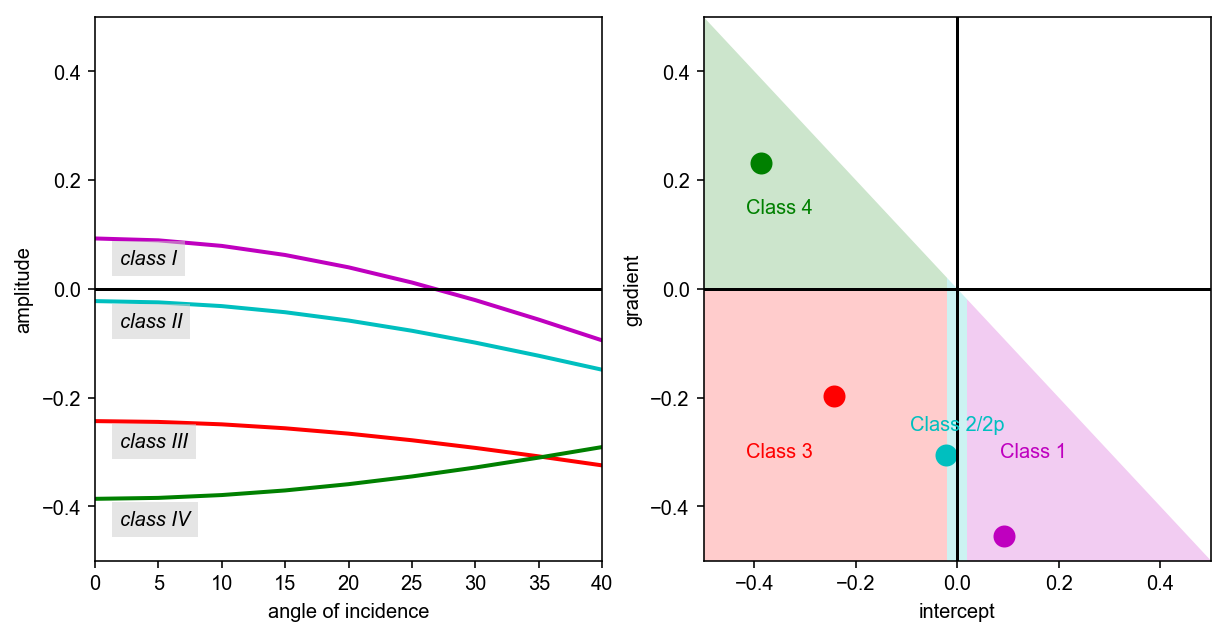

In [3]:
ang=np.arange(0,60,5)
cc=['m','c','r','g']

f,ax=plt.subplots(1,2, figsize=(10, 5))
for i, val in enumerate(avocl):
    amp0=b.reflection.shuey2(shale[i,0],shale[i,1],shale[i,2],ssbri[i,0],ssbri[i,1],ssbri[i,2],ang)
    amp1=b.reflection.shuey2(shale[i,0],shale[i,1],shale[i,2],ssgas[i,0],ssgas[i,1],ssgas[i,2],ang)
    tmp0=b.reflection.shuey2(shale[i,0],shale[i,1],shale[i,2],ssbri[i,0],ssbri[i,1],ssbri[i,2],30,terms=True)
    tmp1=b.reflection.shuey2(shale[i,0],shale[i,1],shale[i,2],ssgas[i,0],ssgas[i,1],ssgas[i,2],30,terms=True)
    Ib, Gb = tmp0[0],tmp0[1] / np.sin(np.radians(30))**2
    Ig, Gg = tmp1[0],tmp1[1] / np.sin(np.radians(30))**2
    ax[0].plot(ang, amp1, color=cc[i], lw=2, ls='-', label=val+' (gas)')
    ax[0].axhline(0, color='k')
    ax[0].set_xlabel('angle of incidence'), ax[0].set_ylabel('amplitude')
    ax[0].set_xlim(0, 40)
    ax[0].text(2,amp1[0]-.02,avocl[i], style='italic', fontsize=10, ha='left', va='top', bbox=dict(fc='0.8', ec='none',alpha=0.5))
    ax[1].plot(Ig, Gg, color=cc[i], marker='o', ms=10, label=val+' (gas)')
    ax[1].axhline(0, color='k'), ax[1].axvline(0, color='k')
    ax[1].set_xlabel('intercept'), ax[1].set_ylabel('gradient')
    ax[1].set_xlim(-.5, .5)
    # draw avo classes areas
    cl1_area = patches.Rectangle((0.02,-1),.98,1,edgecolor='None',facecolor='m',alpha=0.2)
    cl2_area = patches.Rectangle((-0.02,-1),.04,2,edgecolor='None',facecolor='c',alpha=0.2)
    cl3_area = patches.Rectangle((-1,-1),.98,1,edgecolor='None',facecolor='r',alpha=0.2)
    cl4_area = patches.Rectangle((-1,0),.98,1,edgecolor='None',facecolor='g',alpha=0.2)
    for aa in ax:
        aa.grid()
        aa.set_ylim(-.5, .5)
background = patches.Polygon([[-1, 1], [1, -1], [1, 1]],facecolor='w')
ax[1].add_patch(cl1_area)
ax[1].add_patch(cl2_area)
ax[1].add_patch(cl3_area)
ax[1].add_patch(cl4_area)
ax[1].add_patch(background)
ax[1].text(.15,-.3,'Class 1',ha='center',va='center',color='m')
ax[1].text(0,-.25,'Class 2/2p',ha='center',va='center', color='c')
ax[1].text(-.35,-.3,'Class 3',ha='center',va='center', color='r')
ax[1].text(-.35,.15,'Class 4',ha='center',va='center', color='g')

In [4]:
def avomod1(vp1=2192,vs1=818,rho1=2.16,vp2=1542,vs2=901,rho2=1.88,angmin=0,angmax=30,polarity='normal',black='False',method='shuey'):
    n_samples = 500
    gain=10
    interface=int(n_samples/2)
    ang = np.arange(angmin,angmax+1,1)
    z = np.arange(n_samples)
    
    # build Ip and Vp/Vs logs
    ip, vpvs = (np.zeros(n_samples) for _ in range(2))
    ip[:interface]=vp1*rho1
    ip[interface:]=vp2*rho2
    vpvs[:interface]=np.true_divide(vp1,vs1)
    vpvs[interface:]=np.true_divide(vp2,vs2)
    
    # calculate avo curve, intercept and gradient
    if method is 'shuey':
        avo = b.reflection.shuey2(vp1,vs1,rho1,vp2,vs2,rho2,ang)
    elif method is 'zoeppritz':
        avo = b.reflection.zoeppritz(vp1,vs1,rho1,vp2,vs2,rho2,ang)
    ang0 = np.sin(np.radians(ang))**2
    G,I = np.polyfit(ang0,avo,1)
        
    # create synthetic gather
    wavelet=b.filters.ricker(.25, 0.001, 10)
    if polarity is not 'normal':
        print('==> polarity: SEG-Reverse (+AI --> trough)')
        avo *= -1
    else:
        print('==> polarity: SEG-Normal (+AI --> peak)')

    # builds prestack gather model
    rc, syn = (np.zeros((n_samples,ang.size)) for _ in range(2))
    rc[interface,:]=avo
    for i in range(ang.size):
        syn[:,i]=np.convolve(rc[:,i],wavelet,mode='same')

    # do the plot
    f=plt.subplots(figsize=(10, 5))
    ax0 = plt.subplot2grid((1,7), (0,0), colspan=1)
    ax1 = plt.subplot2grid((1,7), (0,1), colspan=1)
    ax2 = plt.subplot2grid((1,7), (0,2), colspan=1)
    ax3 = plt.subplot2grid((1,7), (0,3), colspan=2)
    ax4 = plt.subplot2grid((1,7), (0,5), colspan=2)
    ax0.plot(ip, z, '-k', lw=4)
    ax0.set_xlabel('AI [m/s*g/cc]')
    ax0.margins(x=0.5)
    ax1.plot(vpvs, z, '-k', lw=4)
    ax1.set_xlabel('Vp/Vs')
    ax1.margins(x=0.5)
    opz1={'color':'k','linewidth':2}
    opz2={'linewidth':0, 'alpha':0.6}
    for i in range(0, ang.size,10):
        trace=gain*syn[:,i] / np.max(np.abs(syn))
        ax2.plot(i+trace,z,**opz1)
        if black==False:
            ax2.fill_betweenx(z,trace+i,i,where=trace+i>i,facecolor=[0.6,0.6,1.0],**opz2)
            ax2.fill_betweenx(z,trace+i,i,where=trace+i<i,facecolor=[1.0,0.7,0.7],**opz2)
        else:
            ax2.fill_betweenx(z,trace+i,i,where=trace+i>i,facecolor='black',**opz2)
        ax2.set_xticklabels([])
    ax2.margins(x=0.05)        
    ax3.plot(ang, avo,'-k', lw=4)
    ax3.axhline(0, color='k', lw=1)
    ax3.set_xlabel('angle of incidence')
    ax3.margins(y=0.5)
    ax4.plot(I,G,'ko',ms=10,mfc='none',mew=2)
    ax4.axhline(0, color='k', lw=1), ax4.axvline(0, color='k', lw=1)
    ax4.set_xlabel('intercept'), ax4.set_ylabel('gradient')
    ax4.margins(0.5)
    ax4.xaxis.set_label_position('top'), ax4.xaxis.tick_top()
    ax4.yaxis.set_label_position('right'), ax4.yaxis.tick_right()
    for aa in [ax0, ax1, ax2]:
        aa.invert_yaxis()
        aa.xaxis.tick_top()
        plt.setp(aa.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
        aa.set_yticklabels([])
    plt.tight_layout()

<function __main__.avomod1>

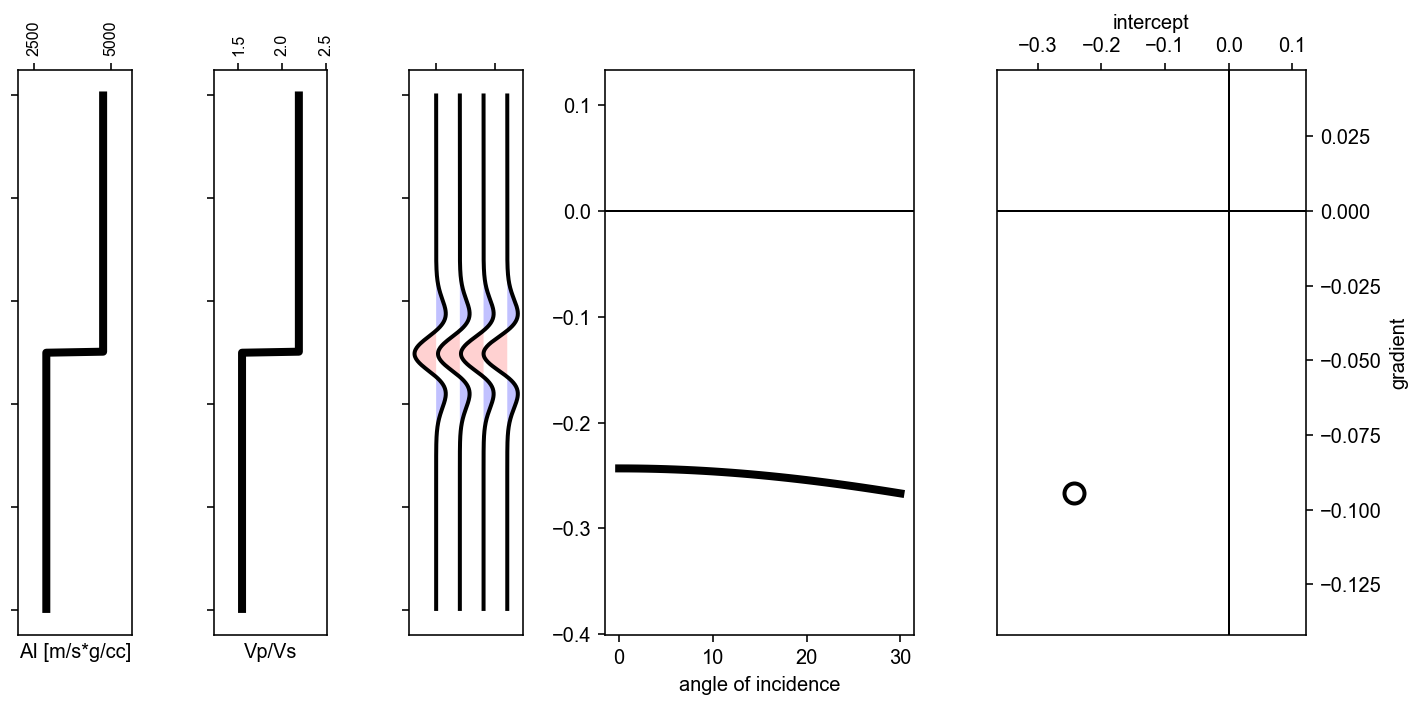

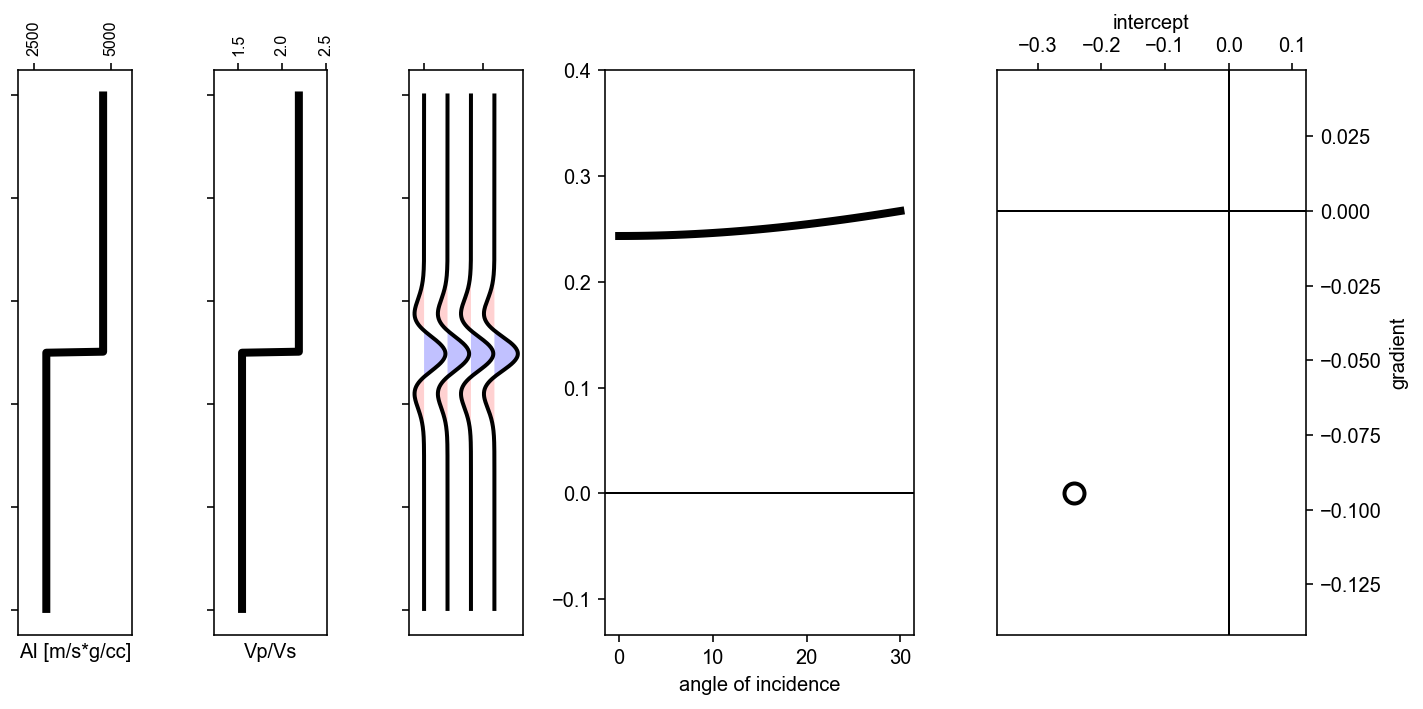

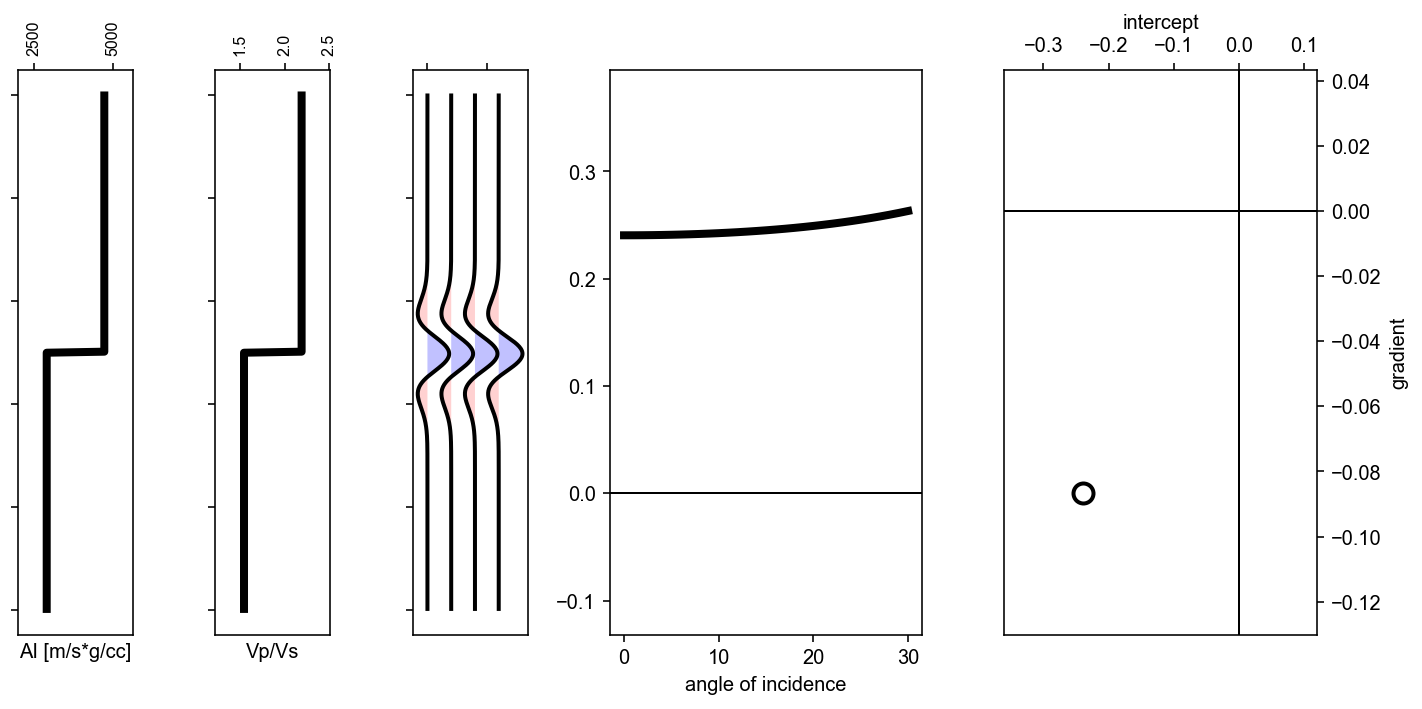

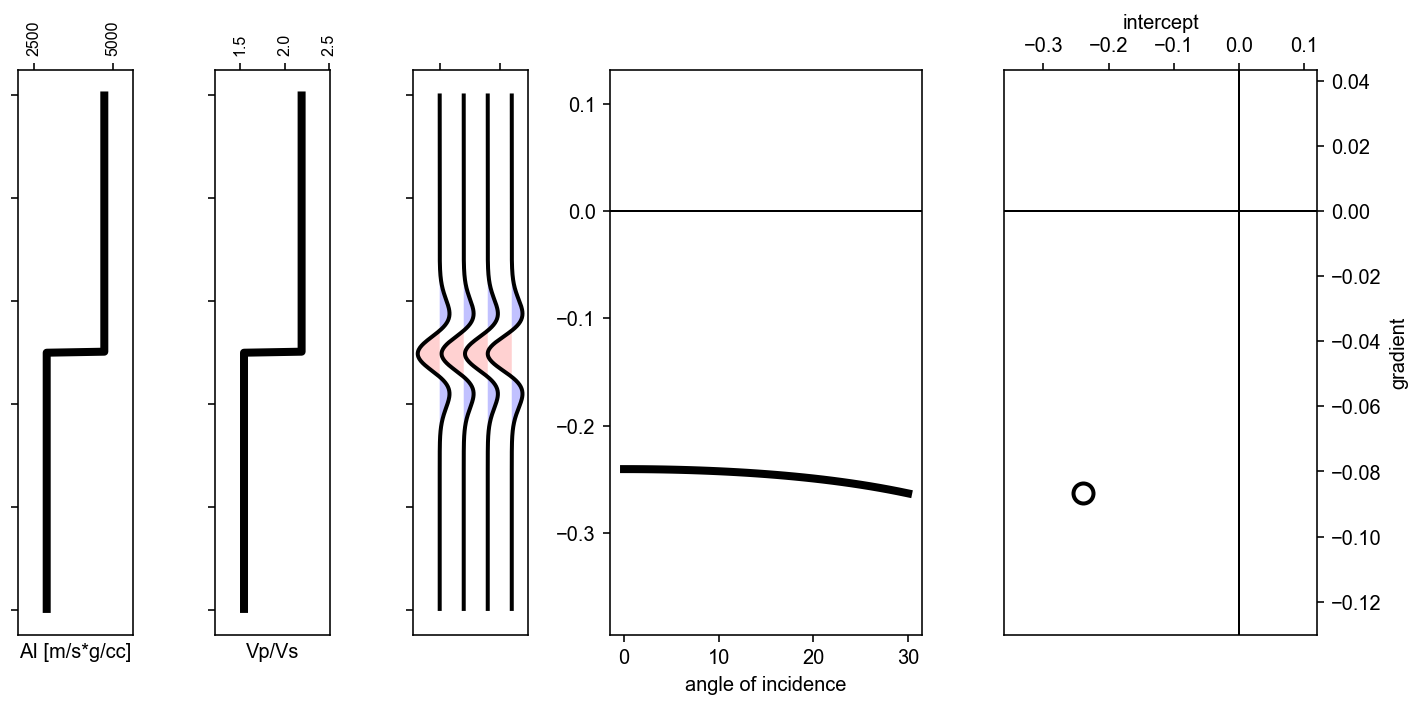

In [5]:
interact(avomod1,vp1=(1500,6000,100),vp2=(1500,6000,100),vs1=(1000,3000,100),vs2=(1000,3000,100),rho1=(1.5,3.0,0.1),rho2=(1.5,3.0,0.1),method=['shuey','zoeppritz'], angmin=fixed(0), angmax=(30,60,10), polarity=['normal','reverse'], black=(False), continuous_update=False)

In [144]:
def avomod2(vp1,vs1,rho1,vp2A,vs2A,rho2A,vp2B,vs2B,rho2B,angmin=0,angmax=30,method='shuey'):
    n_samples = 500
    interface=int(n_samples/2)
    ang = np.arange(angmin,angmax+1,1)
    z = np.arange(n_samples)
    
    # builds Ip and Vp/Vs logs
    ipA,ipB,vpvsA,vpvsB = (np.zeros(n_samples) for _ in range(4))
    ipA[:interface]=vp1*rho1
    ipA[interface:]=vp2A*rho2A
    ipB[:interface]=vp1*rho1
    ipB[interface:]=vp2B*rho2B
    vpvsA[:interface]=np.true_divide(vp1,vs1)
    vpvsA[interface:]=np.true_divide(vp2A,vs2A)
    vpvsB[:interface]=np.true_divide(vp1,vs1)
    vpvsB[interface:]=np.true_divide(vp2B,vs2B)

    # calculates avo curve, intercept and gradient
    if method is 'shuey':
        avoA = b.reflection.shuey2(vp1,vs1,rho1,vp2A,vs2A,rho2A,ang)
        avoB = b.reflection.shuey2(vp1,vs1,rho1,vp2B,vs2B,rho2B,ang)
    elif method is 'zoeppritz':
        avoA = b.reflection.zoeppritz(vp1,vs1,rho1,vp2A,vs2A,rho2A,ang)
        avoB = b.reflection.zoeppritz(vp1,vs1,rho1,vp2B,vs2B,rho2B,ang)
    ang0=np.sin(np.radians(ang))**2
    GA,IA=np.polyfit(ang0,avoA,1)
    GB,IB=np.polyfit(ang0,avoB,1)

    # do the plot
    f=plt.subplots(figsize=(10, 5))
    ax0 = plt.subplot2grid((1,6), (0,0), colspan=1)
    ax1 = plt.subplot2grid((1,6), (0,1), colspan=1)
    ax2 = plt.subplot2grid((1,6), (0,2), colspan=2)
    ax3 = plt.subplot2grid((1,6), (0,4), colspan=2)
    ax0.plot(ipB, z, '-r', lw=4)
    ax0.plot(ipA, z, '-k', lw=4)
    ax0.set_xlabel('AI [m/s*g/cc]')
    ax0.margins(x=0.5)
    ax1.plot(vpvsB, z, '-r', lw=4)
    ax1.plot(vpvsA, z, '-k', lw=4)
    ax1.set_xlabel('Vp/Vs')
    ax1.margins(x=0.5)
    ax2.plot(ang, avoB,'-r', lw=4)
    ax2.plot(ang, avoA,'-k', lw=4)
    ax2.axhline(0, color='k', lw=1)
    ax2.set_xlabel('angle of incidence')
    ax2.margins(y=0.5)
    ax3.plot(IB,GB,'ro',ms=15,mfc='r',mew=1)
    ax3.plot(IA,GA,'ko',ms=15,mfc='k',mew=1)
    ax3.axhline(0, color='k', lw=1), ax3.axvline(0, color='k', lw=1)
    ax3.set_xlabel('intercept'), ax3.set_ylabel('gradient')
    ax3.margins(0.5)
    ax3.xaxis.set_label_position('top'), ax3.xaxis.tick_top()
    ax3.yaxis.set_label_position('right'), ax3.yaxis.tick_right()
    for aa in [ax0, ax1]:
        aa.invert_yaxis()
        aa.xaxis.tick_top()
        plt.setp(aa.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
        aa.set_yticklabels([])
    plt.tight_layout()

In [147]:
def make_avo_explorer(avoclass=3, fluid='gas', phimod=0.0):
    shale = np.array([[3094,1515,2.40], [2643,1167,2.29], [2192,818,2.16], [3240,1620,2.34]])
    ssbri = np.array([[4115,2453,2.32,.2], [3048,1595,2.23,.25], [2134,860,2.11,.33], [2590,1060,2.21,.18]])
    vp1,vs1,rho1=shale[avoclass-1,0],shale[avoclass-1,1],shale[avoclass-1,2]
    vp2,vs2,rho2=ssbri[avoclass-1,0],ssbri[avoclass-1,1],ssbri[avoclass-1,2]    
    phi2 = ssbri[avoclass-1,3]+phimod

    # elastic parameters for toy-fluid replacement
    k0 = 37.00
    rhob, kb = 1.09,  2.20
    if fluid is 'gas':
        rhof_new, kf_new = 0.40,  0.02 # gas density & bulk modulus
    else:
        rhof_new, kf_new = 0.80,  1.02 # oil density & bulk modulus 
    vp2B,vs2B,rho2B=b.rockphysics.avseth_fluidsub(vp2,vs2,rho2*1e3,phi2,rhob*1e3,rhof_new*1e3,k0*1e9,kb*1e9,kf_new*1e9)
    rho2B /= 1e3

    print('Shale:  Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vp1,vs1,rho1))
    print('Sand (brine): Vp={:.0f}, Vs={:.0f}, rho={:.2f}, porosity={:.2f}'.format(vp2,vs2,rho2,phi2))
    print('Sand ({:s}): Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(fluid,vp2B,vs2B,rho2B))

    avomod2(vp1,vs1,rho1,vp2,vs2,rho2,vp2B,vs2B,rho2B,angmin=0,angmax=30,method='shuey')

Shale:  Vp=2192, Vs=818, rho=2.16
Sand (brine): Vp=2134, Vs=860, rho=2.11, porosity=0.33
Sand (gas): Vp=1521, Vs=911, rho=1.88


<function __main__.make_avo_explorer>

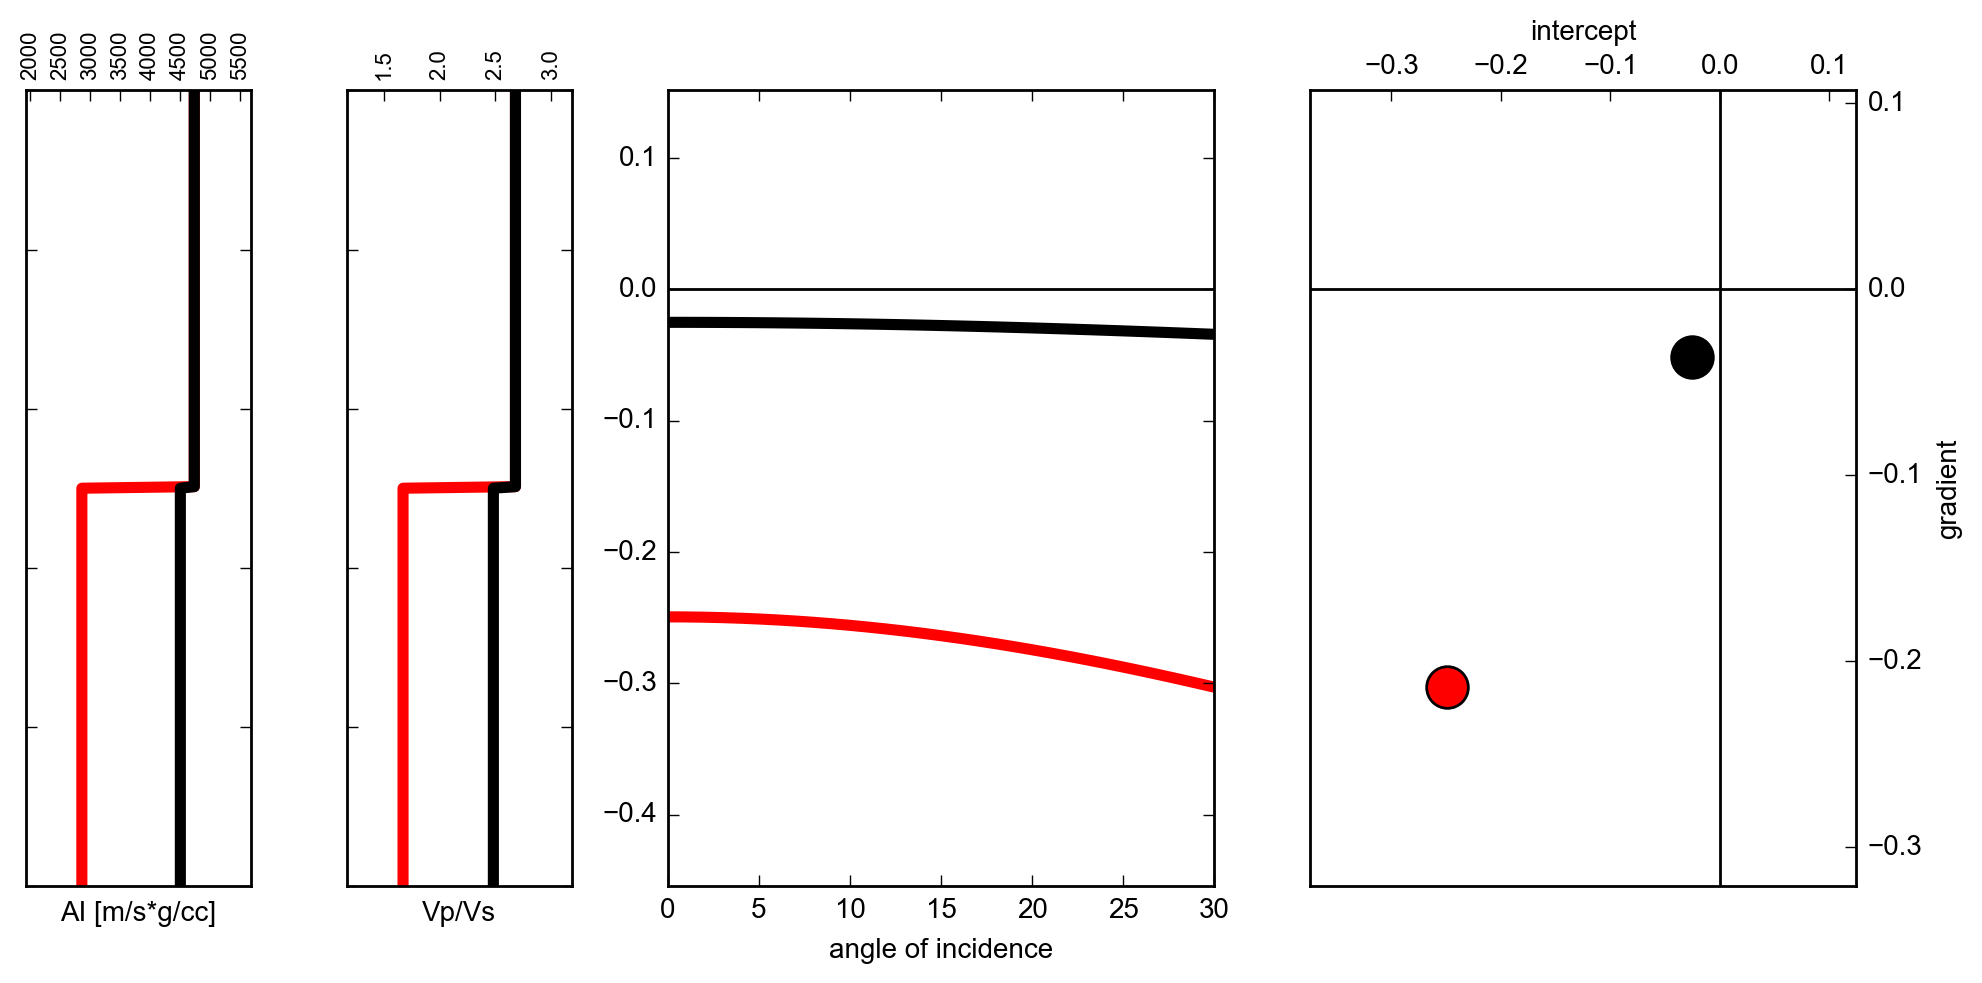

In [151]:
interact(make_avo_explorer,phimod=(-0.1,0.1,0.02),avoclass={'Class I':1,'Class II':2,'Class III':3,'Class IV':4},fluid=['oil','gas'], continuous_update=False)